In [1]:
import hydra
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
import torch
import torchvision.transforms as T
import numpy as np
from nltk.tokenize.treebank import TreebankWordDetokenizer

from exp.gpv.models.gpv import GPV
from utils.detr_misc import collate_fn
from inference_util import *

## Load config

In [2]:
with initialize(config_path='configs',job_name='inference'):
    cfg = compose(config_name='exp/gpv_inference')

## Create model and load checkpoint

In [3]:
model = GPV(cfg.model).cuda().eval()
loaded_dict = torch.load(cfg.ckpt, map_location='cuda:0')['model']
state_dict = model.state_dict()
for k,v in state_dict.items():
    state_dict[k] = loaded_dict[f'module.{k}']
    state_dict[k].requires_grad = False
model.load_state_dict(state_dict)

<All keys matched successfully>

## Functions to preprocess inputs and decode outputs

In [4]:
transforms = T.Compose([
    T.ToPILImage(mode='RGB'),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [5]:
def preprocess(inputs,transforms):
    proc_inputs = []
    for img_path, query in inputs:
        img,_ = read_image(img_path,resize_image=True)
        proc_img = (255*img).astype(np.uint8)
        proc_img = transforms(proc_img).cuda()
        proc_inputs.append((proc_img,query))
    
    return collate_fn(proc_inputs)

In [6]:
def decode_outputs(outputs):
    detokenizer = TreebankWordDetokenizer()
    relevance = outputs['pred_relevance_logits'].softmax(-1).detach().cpu().numpy()
    pred_boxes = outputs['pred_boxes'].detach().cpu().numpy()
    B = pred_boxes.shape[0]
    
    decoded_outputs = []
    for b in range(B):
        scores, boxes = zip(*sorted(zip(
            relevance[b,:,0].tolist(),pred_boxes[b].tolist()),
            key=lambda x: x[0],reverse=True))
        scores = np.array(scores,dtype=np.float32)
        boxes = np.array(boxes,dtype=np.float32)
        answers = [detokenizer.detokenize(ans) for ans in outputs['answers'][b]]
        decoded_outputs.append({
            'answers': answers,
            'answer_probs': outputs['answer_probs'][b],
            'boxes': boxes,
            'relevance': scores})
    
    return decoded_outputs

## Ask GPV-1

Let us query GPV-1 about these images!

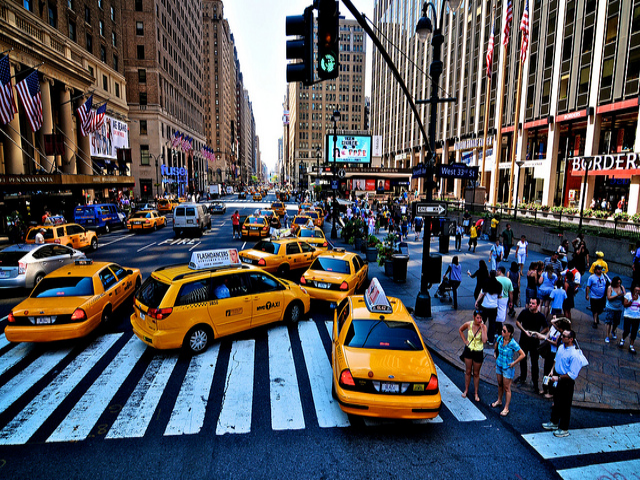

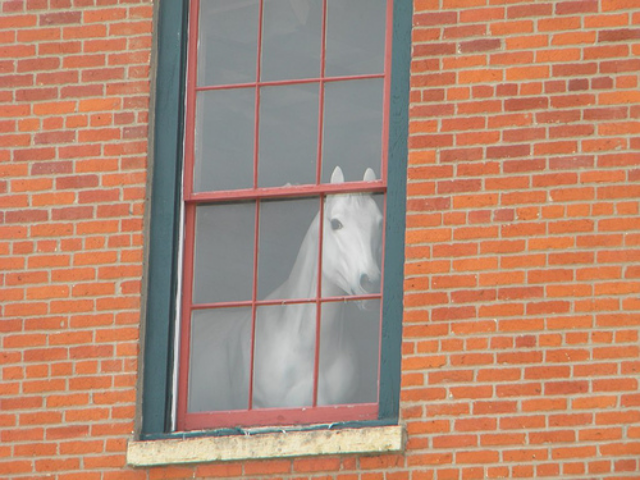

In [7]:
img1,_ = read_image('assets/busy_street.png',resize_image=True)
img2,_ = read_image('assets/white_horse.png',resize_image=True)
imshow((255*img1[:,:,::-1]).astype(np.uint8)) # scale pixel values, RGB to BGR (because imshow uses opencv), and convert to uint8
imshow((255*img2[:,:,::-1]).astype(np.uint8))


We have trained GPV-1 on the following tasks and provide example queries:
- *VQA*: `What color is the dog?`
- *Localization*: `Find the dog.`
- *Captioning*: `Describe the image.`
- *Classification*: `What is this?` (The image is assumed to be a tight crop of the object)

Below we input image and query pairs for GPV-1 to answer.


In [8]:
inputs = [
    ('assets/busy_street.png','What is the color of the cars?'),
    ('assets/busy_street.png','Describe the image.'),
    ('assets/busy_street.png','Find all the people.'),
    ('assets/white_horse.png','Where is the horse?'),
    ('assets/white_horse.png','What color is the horse?'),
    ('assets/white_horse.png','What is the white object?'),
    ('assets/white_horse.png','What is the color of the wall?'),
    ('assets/white_horse.png','Describ the image.')
]

## Run inference

Set `beam_size` to 1 for greedy decoding of answers or to an integer value greater than 1 for beam search.

In [9]:
images, queries = preprocess(inputs,transforms)
outputs = model.forward_beam_search(images,queries,beam_size=5)
predictions = decode_outputs(outputs)

## Visualize text and box predictions

GPV-1 always outputs what it thinks is regions in the image that are relevant to the query and text. For some queries, the expected output and supervision provided during training is only boxes. In those cases, it is interesting to look at text predictions as they often contain useful although unsolicited information. 

--------------------------------------------------------------------------------
Query 0: What is the color of the cars?
Ans 0:
	0: yellow (0.9381)
	1: yellow and blue (0.0607)
	2: yellow, blue (0.0002)
	3: yellow __unk__ (0.0001)
	4: yellow, blue, red, blue (0.0001)
Boxes:


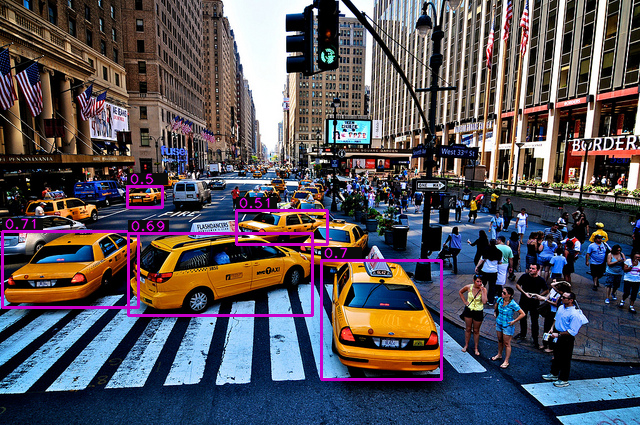

--------------------------------------------------------------------------------
Query 1: Describe the image.
Ans 1:
	0: a city street filled with lots of traffic. (0.0045)
	1: a bunch of cars that are sitting in the street. (0.0037)
	2: a busy city street filled with lots of traffic. (0.0035)
	3: a city street filled with lots of traffic surrounded by tall buildings. (0.0018)
	4: a city street filled with lots of traffic and people. (0.0007)
Boxes:


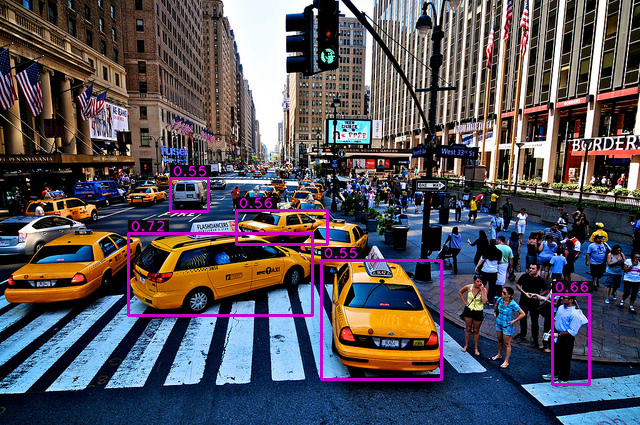

--------------------------------------------------------------------------------
Query 2: Find all the people.
Ans 2:
	0: many cars and pedestrians on a city street (0.0014)
	1: crowd of people walking across a street (0.0007)
	2: many cars and pedestrians on a city street. (0.0007)
	3: crowd of people walking on sidewalk next to cars (0.0005)
	4: crowd of people walking on sidewalk next to traffic. (0.0002)
Boxes:


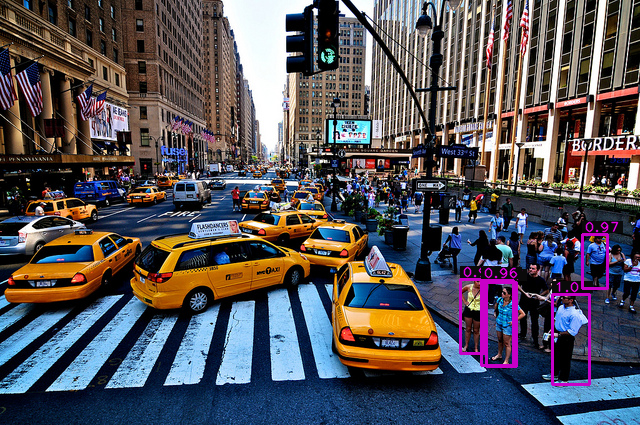

--------------------------------------------------------------------------------
Query 3: Where is the horse?
Ans 3:
	0: outside (0.3477)
	1: behind fence (0.3135)
	2: window (0.1274)
	3: inside (0.0842)
	4: behind door (0.0422)
Boxes:


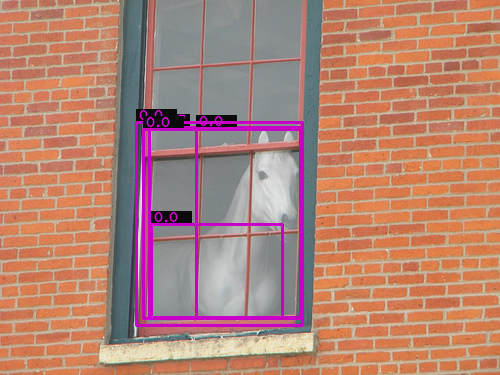

--------------------------------------------------------------------------------
Query 4: What color is the horse?
Ans 4:
	0: white (1.0)
	1: white and black (0.0)
	2: black (0.0)
	3: red (0.0)
	4: white. (0.0)
Boxes:


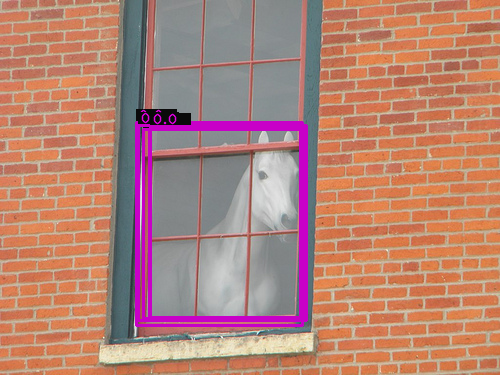

--------------------------------------------------------------------------------
Query 5: What is the white object?
Ans 5:
	0: horse (0.9796)
	1: bear (0.0048)
	2: greek (0.0017)
	3: white horse (0.0011)
	4: tam (0.0008)
Boxes:


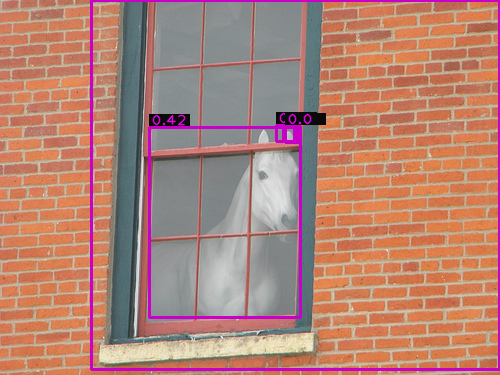

--------------------------------------------------------------------------------
Query 6: What is the color of the wall?
Ans 6:
	0: red (0.9961)
	1: little red (0.0009)
	2: brick (0.0006)
	3: brown (0.0005)
	4: pink (0.0004)
Boxes:


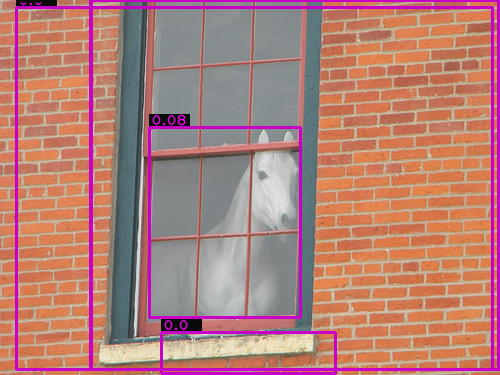

--------------------------------------------------------------------------------
Query 7: Describ the image.
Ans 7:
	0: a white horse looking out of a window. (0.0097)
	1: a white horse looking out of a red brick building. (0.0041)
	2: a white horse is looking out of a window. (0.0038)
	3: a white horse looking out the window of a red brick building. (0.0033)
	4: a white horse is looking out of a red brick building. (0.0011)
Boxes:


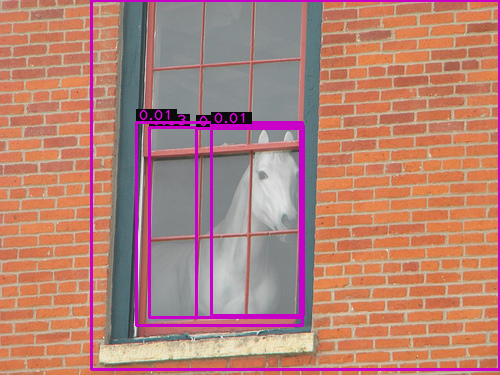

In [10]:
for i in range(len(inputs)):
    img_path, query = inputs[i]
    prediction = predictions[i]
    vis_img = vis_sample(img_path,prediction,5)
    print('-'*80)
    print(f'Query {i}:',query)
    print(f'Ans {i}:')
    for n in range(len(prediction['answers'])):
        answer = prediction['answers'][n]
        answer_prob = round(prediction['answer_probs'][n],4)
        print(f'\t{n}:',answer,f'({answer_prob})')
    
    print('Boxes:')
    imshow(vis_img)